In [2]:
import numpy as np
from matplotlib import pyplot as plt
from utils import *
import pandas as pd
from scipy import stats

## Firstly, read data from file

In [3]:
filename = 'Data/skeleton_xyz_stage_all.csv'
df = pd.read_csv(filename)

### Read in all the stage data, and group each tubule together

In [4]:
stages = df['Stage'].to_numpy().astype('int')
tubules = df['Tubule_ID'].to_numpy().astype('int')
branches = df['Branch_ID'].to_numpy().astype('int')
refs = df['Ref']

datasets = [] 
for i in range(1, 10): 
    mask = (tubules == i)
    tubule_stage = stages[mask] 
    tubule_branches = branches[mask]
    tubule_refs = refs[mask]
    tubule_dataset = [] 
    for j in range(1, tubule_branches[-1]+1):
        mask = (tubule_branches == j)
        branch_stages = tubule_stage[mask]
        branch_dataset = {
            'start': (tubule_refs[mask]).iloc[0], 
            'end': (tubule_refs[mask]).iloc[-1], 
            'stages': branch_stages,
        }
        tubule_dataset.append(branch_dataset)

    datasets.append(tubule_dataset)      

### Print out the start and end points of each tubule to manually read off the longest section (ish) 

In [5]:
for (i, dataset) in enumerate(datasets): 
    print('tubule ID:', i+1)
    for d in dataset: 
        stages = d['stages']     
        print(d['start'], d['end'], len(stages), np.sum(stages==0), np.sum(stages==255))

tubule ID: 1
b4 b5 1663 7 1
b4 b3 217 0 0
b4 R8 5479 11 41
b5 b6 1362 0 0
b5 R5 3671 10 35
b3 b2 4406 9 13
b3 R2 2830 5 0
b2 R4 1669 2 2
b2 b1 240 0 0
b1 R1 3149 4 37
b1 R3 1503 3 0
b6 R7 3628 3 2
b6 R6 2178 8 17
tubule ID: 2
R3 b1 3507 10 59
b1 R1 5794 15 101
b1 R2 593 17 0
tubule ID: 3
b1 R1 8200 9 77
b1 R3 2731 10 52
b1 R2 702 5 66
tubule ID: 4
b1 b2 4444 3 122
b1 b3 2495 3 52
b1 R2 3261 6 11
b2 R6 884 3 0
b2 R8 1167 7 6
b6 R4 1318 3 25
b6 R1 1231 2 0
b6 b5 7220 2 81
b5 b4 1417 2 10
b5 R7 3044 11 48
R5 b4 151 2 5
R3 b3 183 4 0
b3 b4 147 1 0
tubule ID: 5
b1 R1 5117 11 28
b1 R2 1234 3 25
b1 R3 3581 12 14
tubule ID: 6
R2 R1 6629 15 135
tubule ID: 7
R2 R1 12111 52 175
tubule ID: 8
b1 R3 11690 38 121
b1 R2 2698 6 25
b1 R1 384 1 37
tubule ID: 9
b1 R1 3353 11 25
b1 b2 5000 7 250
b1 b3 4062 8 72
b2 R2 1755 8 5
b2 R3 1366 1 25
b3 R4 1223 4 5
b3 b4 6328 18 125
R6 b4 37 0 0
b4 R5 156 1 0


### Extract the longest sections

In [6]:
orders = [[2, 0, 4], [0, 1], [0, 1], [6, 7, 9], [0, 2], [0], [0], [0, 1], [5, 6, 8]]
reverse = [[True, False, False], [False, False], [True, False], [True, False, False], [True, False], [False], [False], [True, False], [True, False, False]]

segments = [] 
for (i, (order, rev, dataset)) in enumerate(zip(orders, reverse, datasets)): 
    print('tubule ID:', i+1)
    segment = [] 
    for (j, segment_index) in enumerate(order): 
        stages = dataset[segment_index]['stages']
        if rev[j]: 
            stages = np.flip(stages)
        segment.extend(stages)
    segment = np.array(segment)
    segments.append(segment)
        
print(list(map(len, segments)))       

tubule ID: 1
tubule ID: 2
tubule ID: 3
tubule ID: 4
tubule ID: 5
tubule ID: 6
tubule ID: 7
tubule ID: 8
tubule ID: 9
[10813, 9301, 10931, 11495, 8698, 6629, 12111, 14388, 7707]


### Replace the invalid datapoints with averages of neighbours 

In [7]:
straight_segments = [] 
for (i, segment) in enumerate(segments): 
    boolean_mask = is_invalid(segment).astype('int')
    left = np.where((np.roll(boolean_mask, -1) - boolean_mask) > 0)[0]
    right = np.where((np.roll(boolean_mask, 1) - boolean_mask) > 0)[0]

    
    if right[0] < left[0]: # invalid segments at the start 
        right = right[1:]
    if left[-1] > right[-1]: # invalid segments at the end 
        left = left[:-1]
    
    for (l, r) in zip(left, right): # pairs of indices between which the values are invalid         
        val = period_average(segment[l], segment[r])
        segment[l+1:r] = val 
        
        
    new_mask = is_invalid(segment)
    straight_segments.append(segment[~new_mask])  

## Perform inference on each tubule separately

Tubule ID:  1


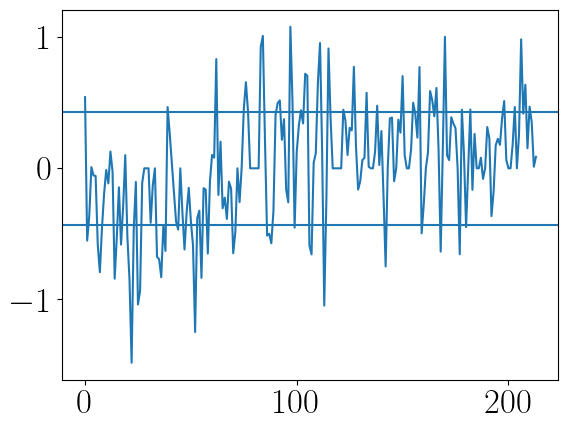

eta:  -0.46081199427154557 , error:  0.05047103153454353 0.2069312292916285
sigma:  0.4219792715180467 , error:  0.014422956260090266 0.04009581840305094
grad:  2.5339249189334145 , error:  0.1955359493923407 3.141592653589793


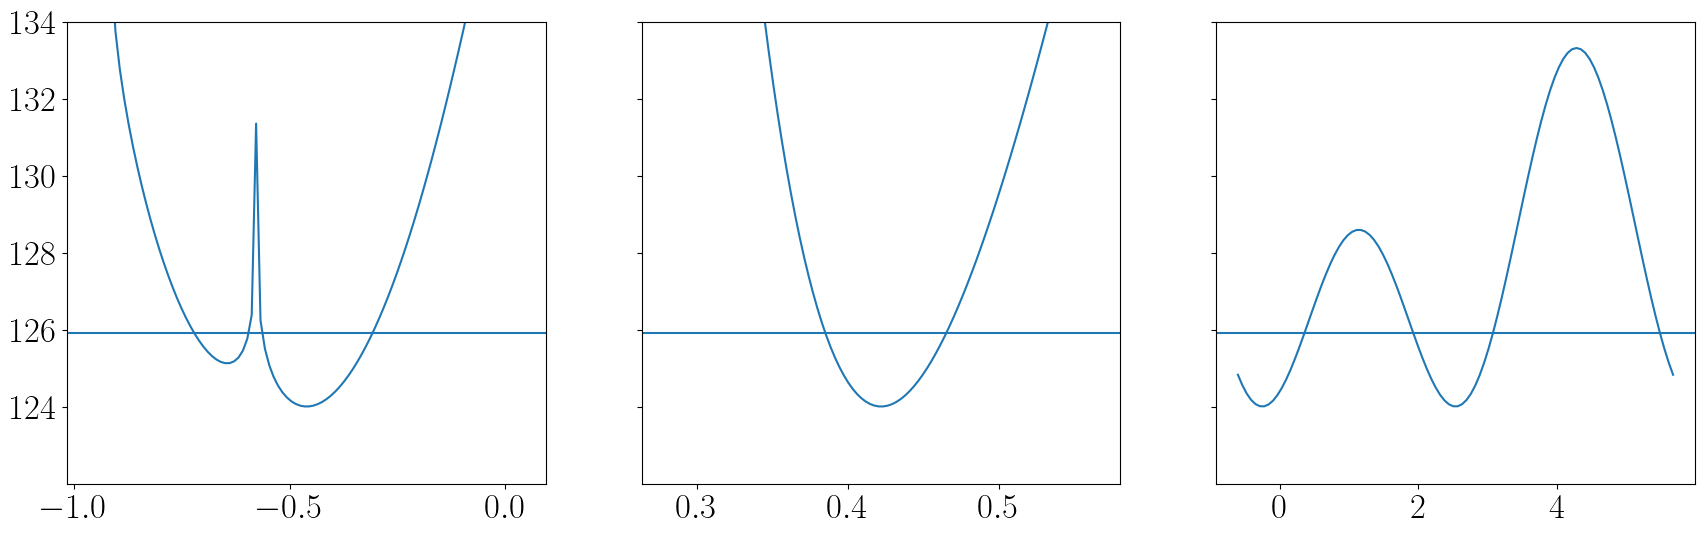

Tubule ID:  2


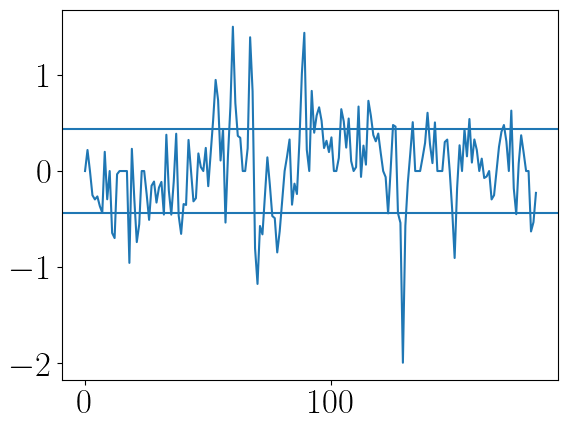

eta:  -0.21638832336879865 , error:  0.05693983391554764 0.2801439828644944
sigma:  0.381028202666236 , error:  0.014044884442397158 0.03932567643871204
grad:  -0.1507810571910801 , error:  0.1875834749698795 3.141592653589793


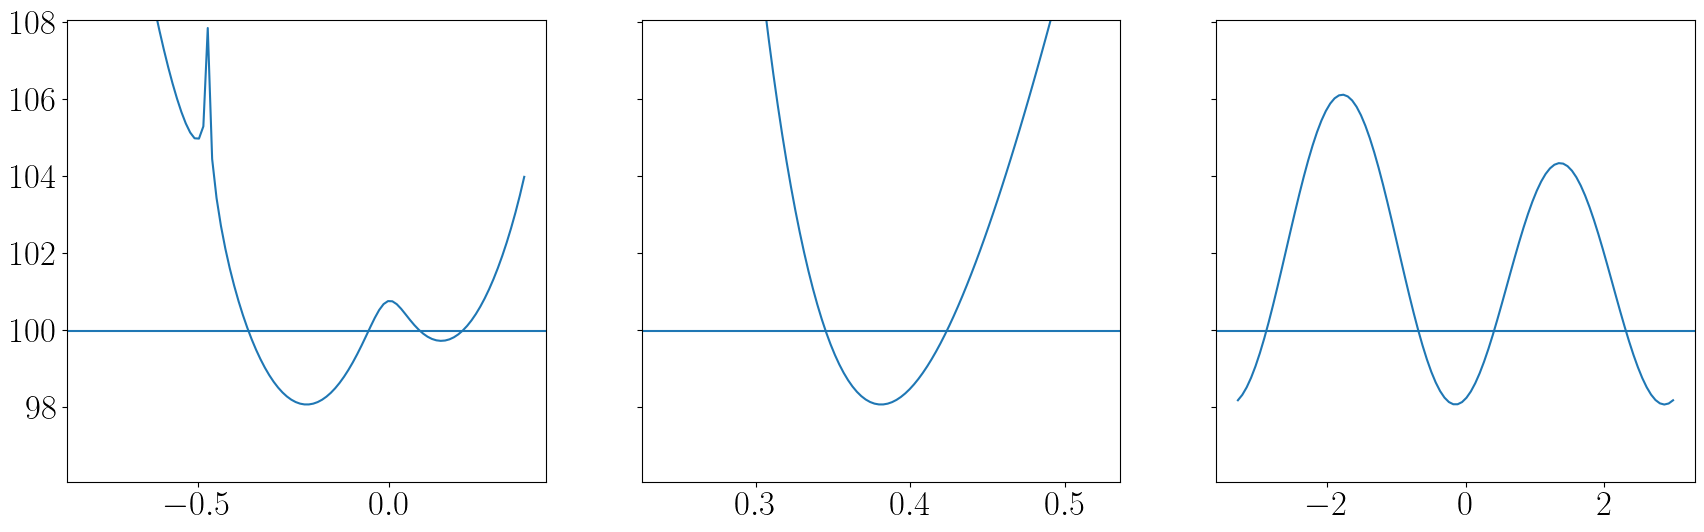

Tubule ID:  3


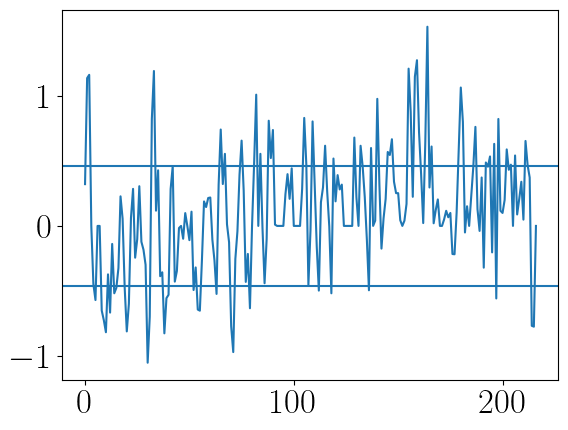

eta:  -0.6381454457602916 , error:  0.04712741998078439 0.1253589371488865
sigma:  0.44950437130504806 , error:  0.015257172149730883 0.04241493857625186
grad:  2.2659007035653556 , error:  0.199715946077243 1.7907078125461822


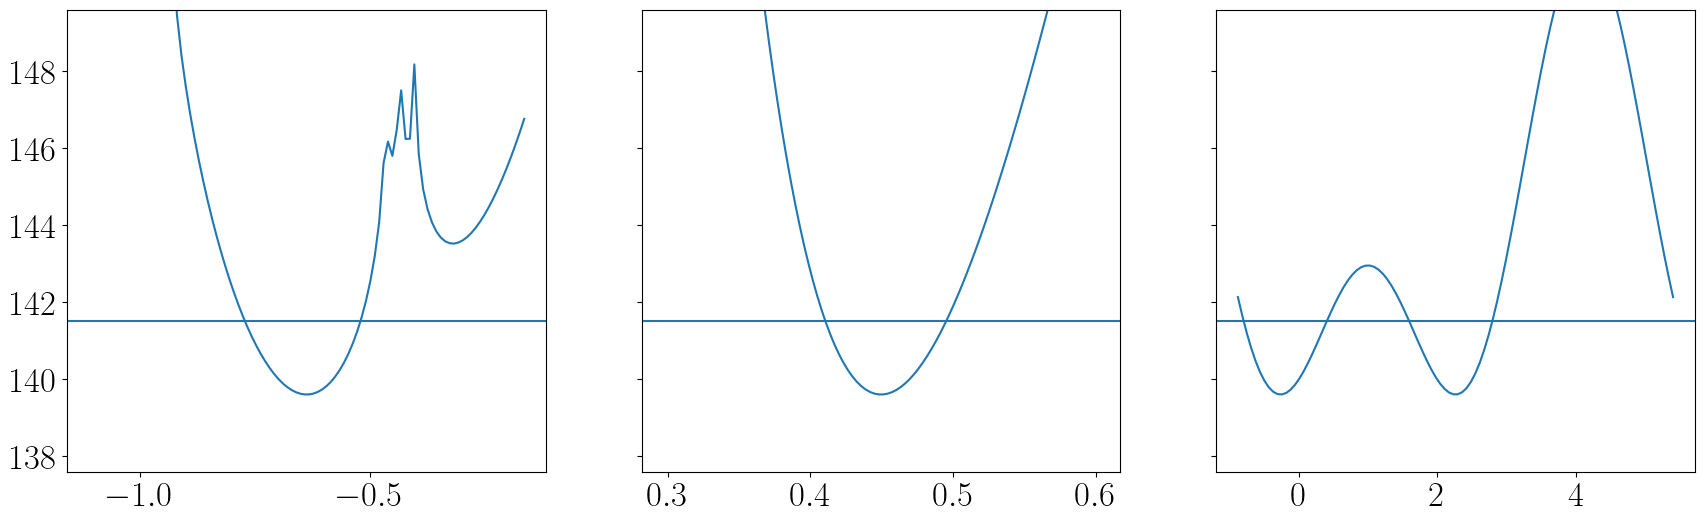

Tubule ID:  4


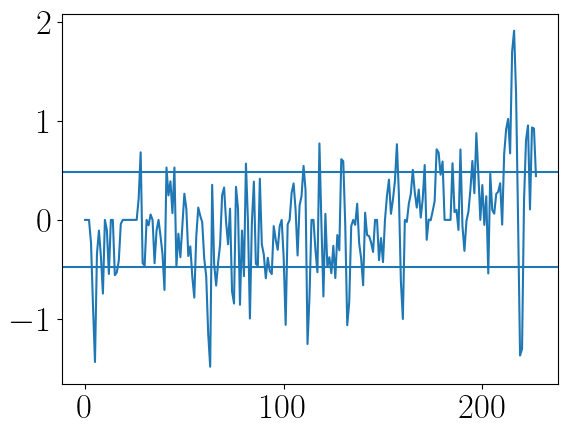

eta:  -0.4891750771273205 , error:  0.04164584496425065 0.10994503070562174
sigma:  0.46566192055501204 , error:  0.015419604717207568 0.04286650111383704
grad:  2.100167054878663 , error:  0.25221233366387114 1.595929068023615


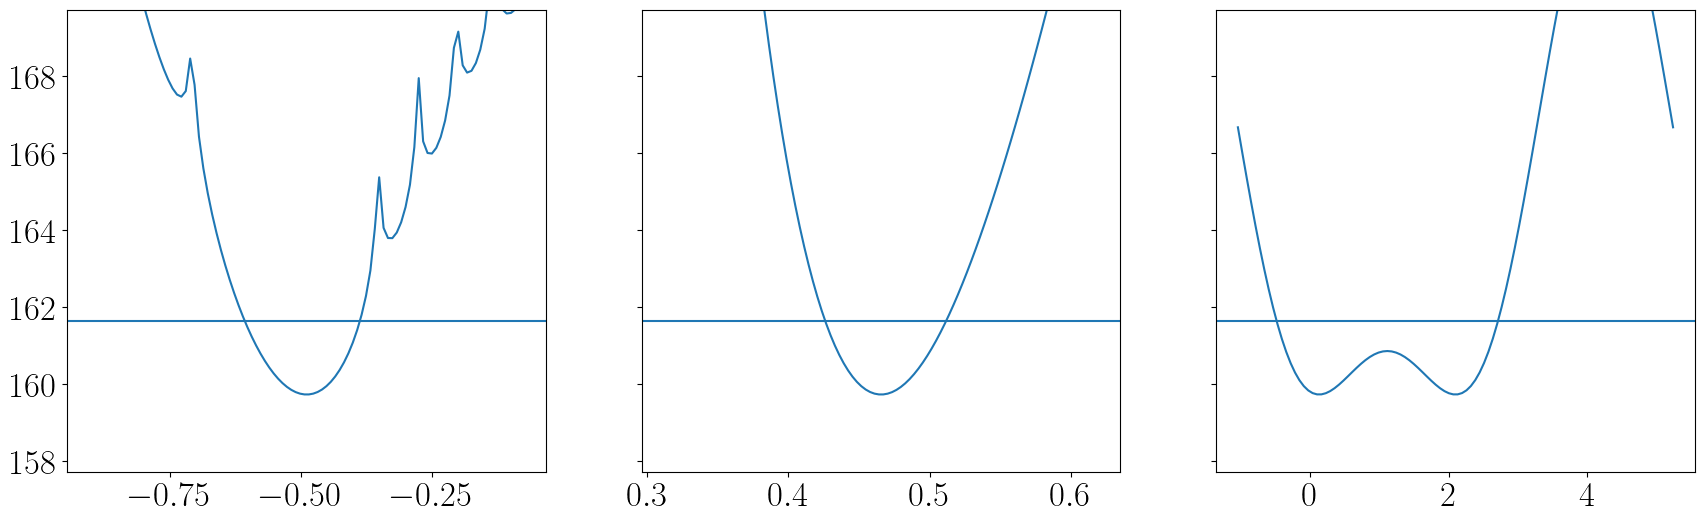

Tubule ID:  5


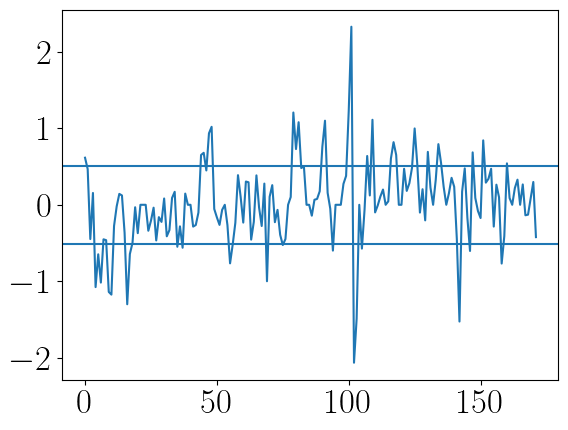

eta:  -0.19571197322006095 , error:  0.04019099897410221 0.2628491332906284
sigma:  0.471937937611012 , error:  0.017992462949557878 0.050019046999770896
grad:  -0.5201731317661125 , error:  0.245949349857007 3.141592653589793


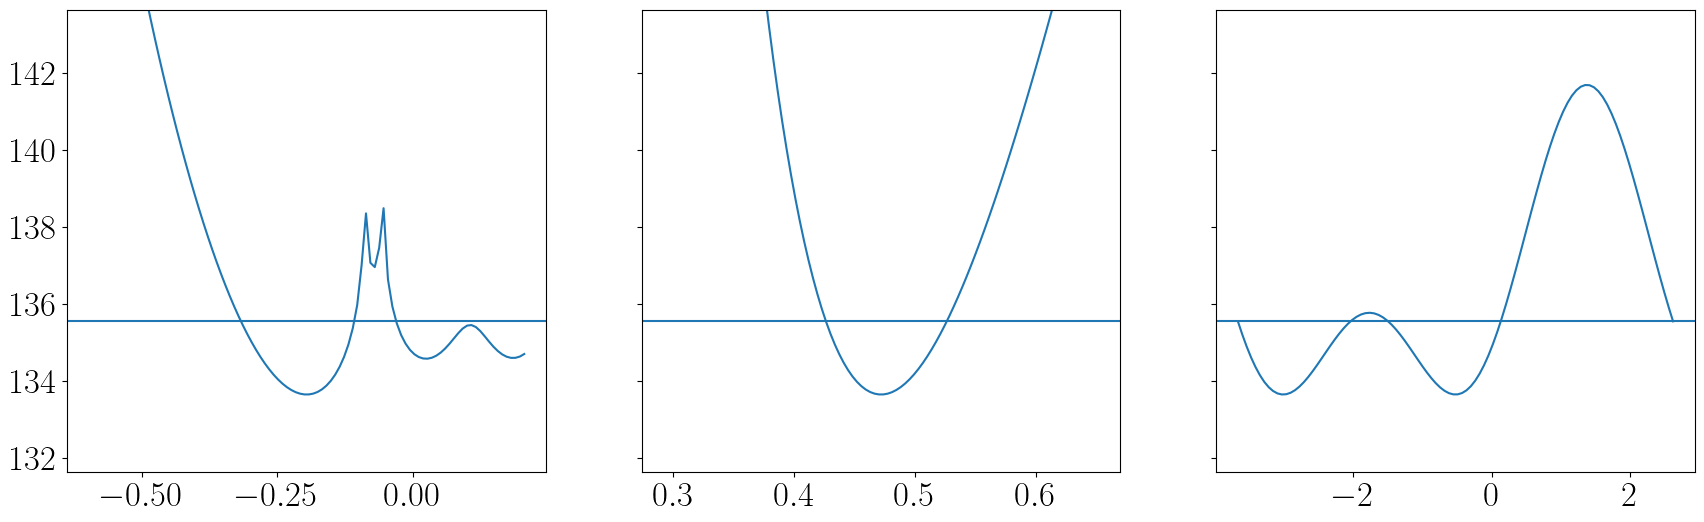

Tubule ID:  6


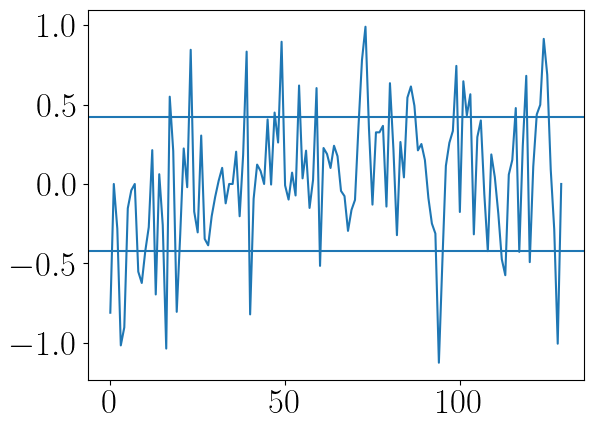

eta:  -0.2681821956371815 , error:  0.07549349924403437 0.20836205791353485
sigma:  0.48383873191629484 , error:  0.02121772807815904 0.05940963861884531
grad:  2.2251766020705386 , error:  0.29677950411135295 1.6084954386379742


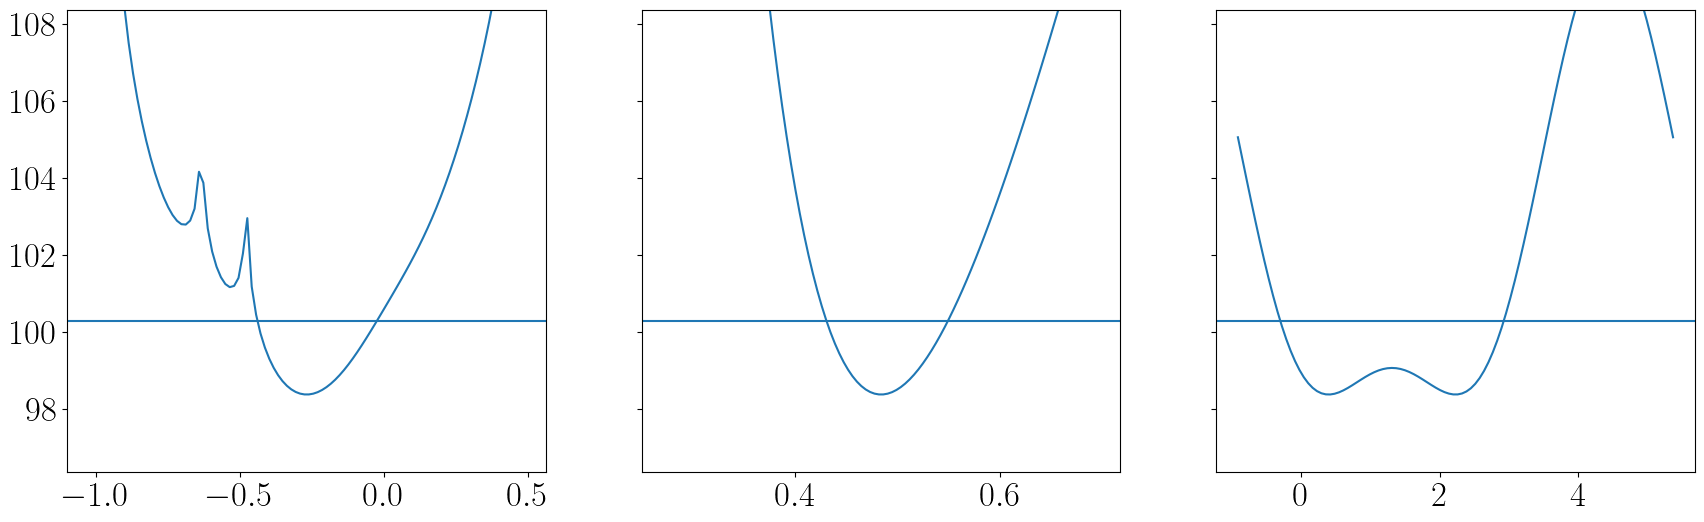

Tubule ID:  7


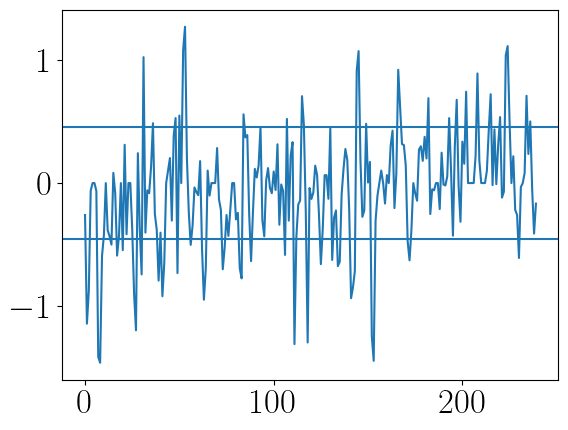

eta:  -0.39467223721292394 , error:  0.03675787301689037 0.16246979873465542
sigma:  0.4705318397486722 , error:  0.015186351576369026 0.04221805738230589
grad:  2.417126783171266 , error:  0.2338129192232184 1.8346901096964392


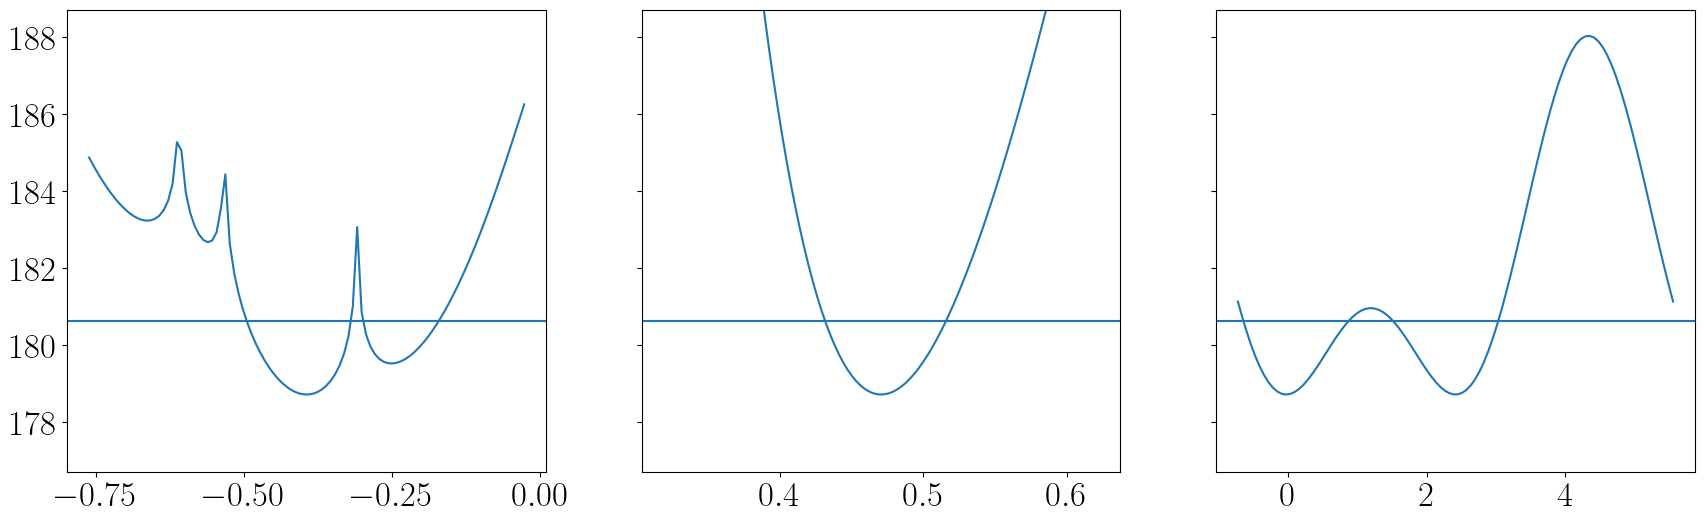

Tubule ID:  8


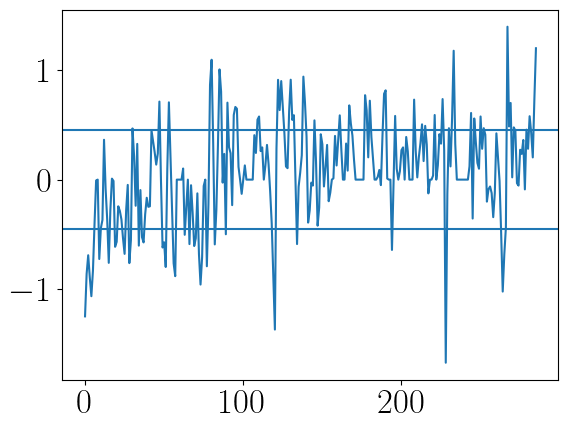

eta:  -0.49198558046380064 , error:  0.044544403854697226 0.11492456194511884
sigma:  0.40196171037686673 , error:  0.011884245972980706 0.03303820380488636
grad:  1.1135468753838742 , error:  0.2572298215815358 0.653451271946677


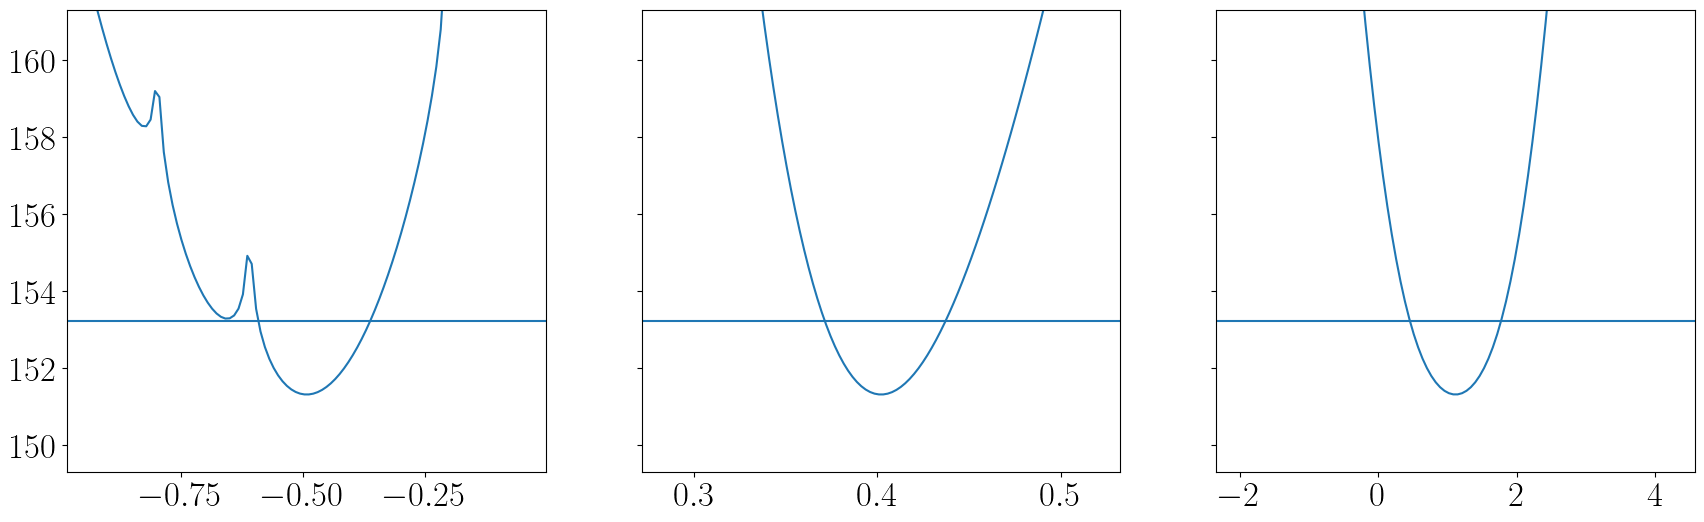

Tubule ID:  9


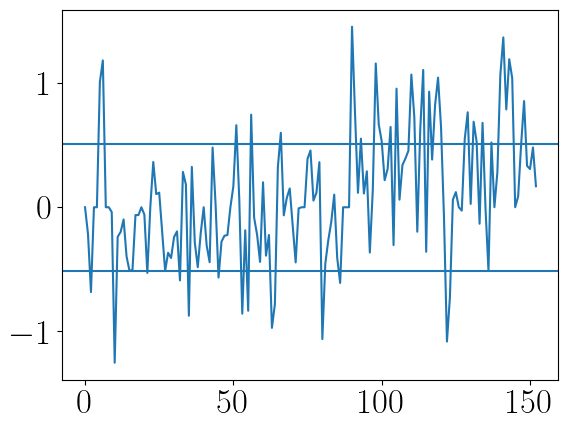

eta:  -0.7863196794117266 , error:  0.05769106700980096 0.14768913154509045
sigma:  0.5425706696310876 , error:  0.021932118071966305 0.060971288240066326
grad:  -0.11107771647355091 , error:  0.25260173158311827 1.6336281798666925


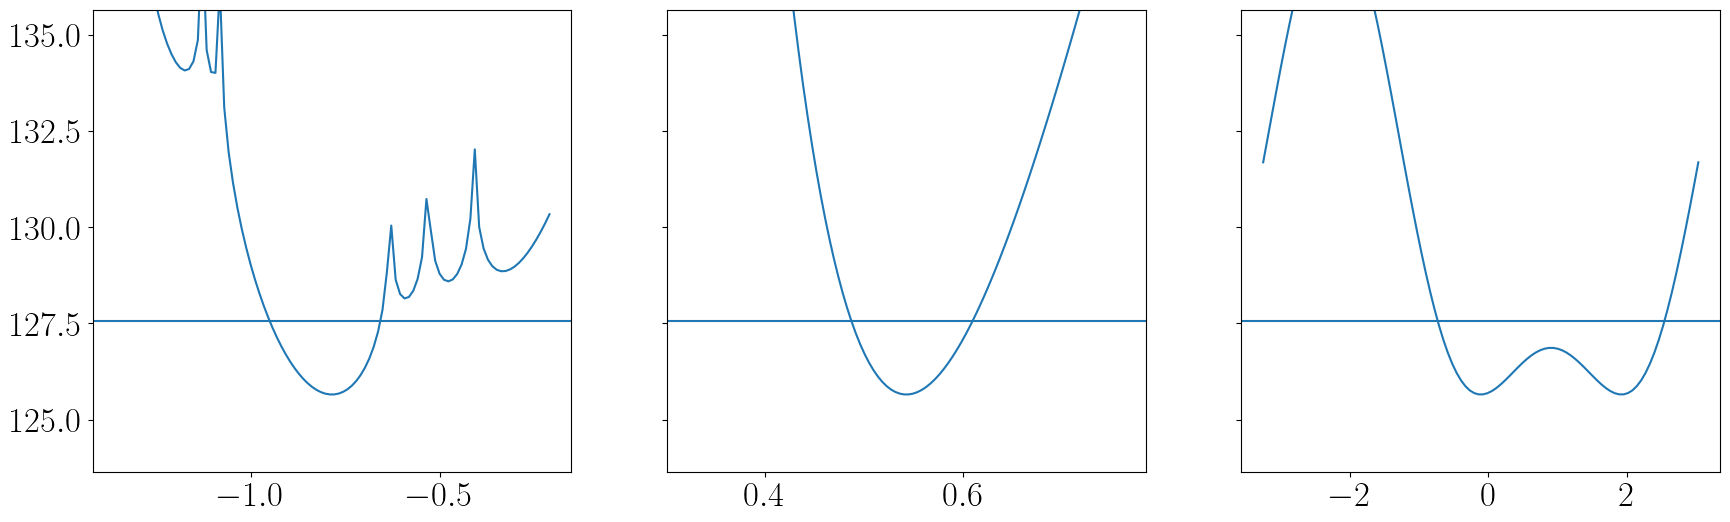

In [8]:
etas = [] 
sigmas = [] 
grads = [] 
etas_err = [] 
sigmas_err = [] 
grads_err = [] 

plt.rc('font', size=25, family='serif')
plt.rc('text', usetex=True)

for (i, stages) in enumerate(straight_segments): 
    phases = np.array(list(map(stage_to_phase, stages)))
    shift(phases)
    theta_smooth = smooth(phases, 50)
    
    print('Tubule ID: ', i+1)

    phi = theta_smooth[1:] - theta_smooth[:-1]
    plt.plot(phi)
    omega = np.mean(2*(1-np.cos(phi)))
    slope = np.sqrt(omega)
    plt.axhline(y=slope)
    plt.axhline(y=-slope)
    plt.show() 
    
    eta, grad = MAP(phi)
    sigma = get_MAP_sigma(phi, eta, grad)
    errs_hess = errors_hess(phi, eta, sigma, grad, diff=1e-4)
    
    widths = np.copy(errs_hess)*10
    widths[-1] = np.pi 
    errs_brute = errors_brute(phi, eta, sigma, grad, diff=widths)
    print('eta: ', eta, ', error: ', errs_hess[0], errs_brute[0])
    print('sigma: ', sigma, ', error: ', errs_hess[1], errs_brute[1])
    print('grad: ', grad, ', error: ', errs_hess[2], errs_brute[2])
    plot_cost(phi, eta, sigma, grad, widths=widths)
    
    etas.append(eta)
    sigmas.append(sigma)
    grads.append(grad)
    etas_err.append(errs_brute[0])
    sigmas_err.append(errs_brute[1])
    grads_err.append(errs_brute[2])
    
    
    

-124.00568883520623
-98.0628615375674
-139.60541693189012
-160.57675726724995
-134.30729135827283
-104.82132389987382
-179.64898348989578
-169.3475818789555
-129.23121322843588


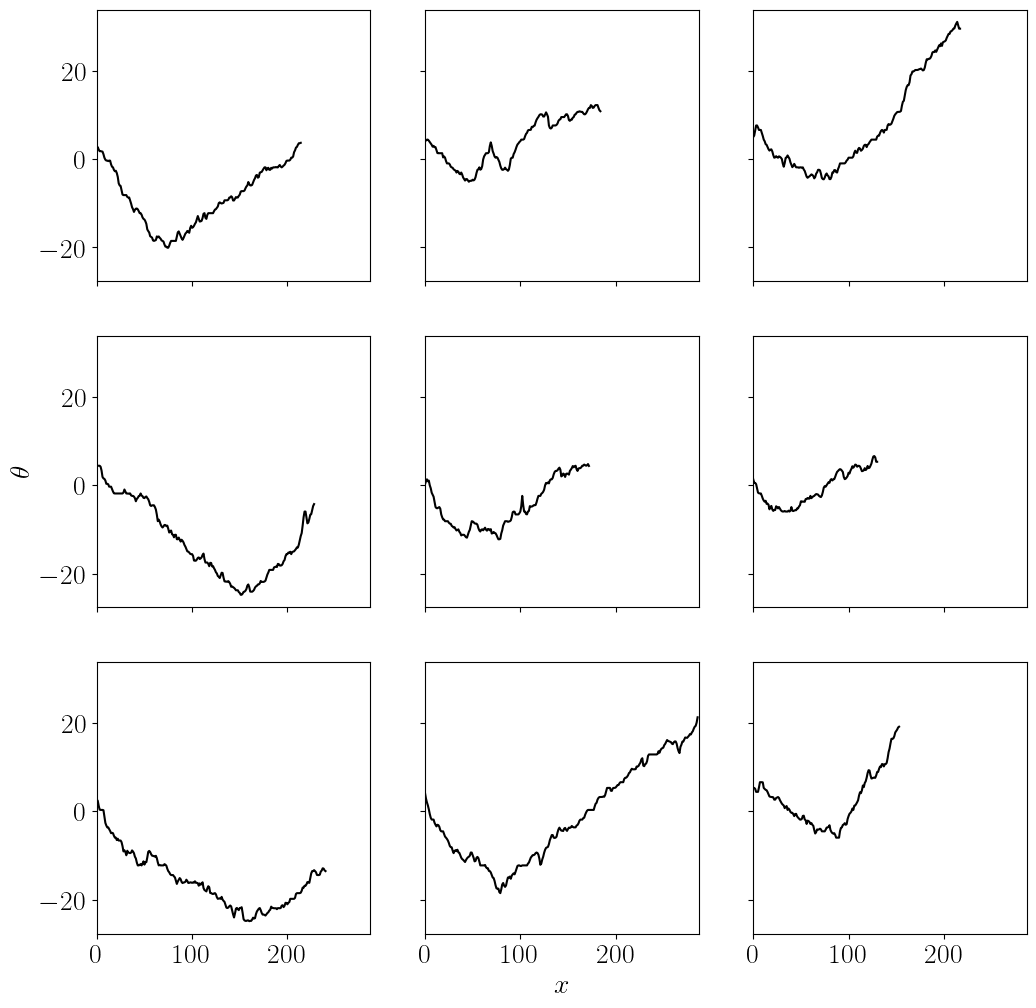

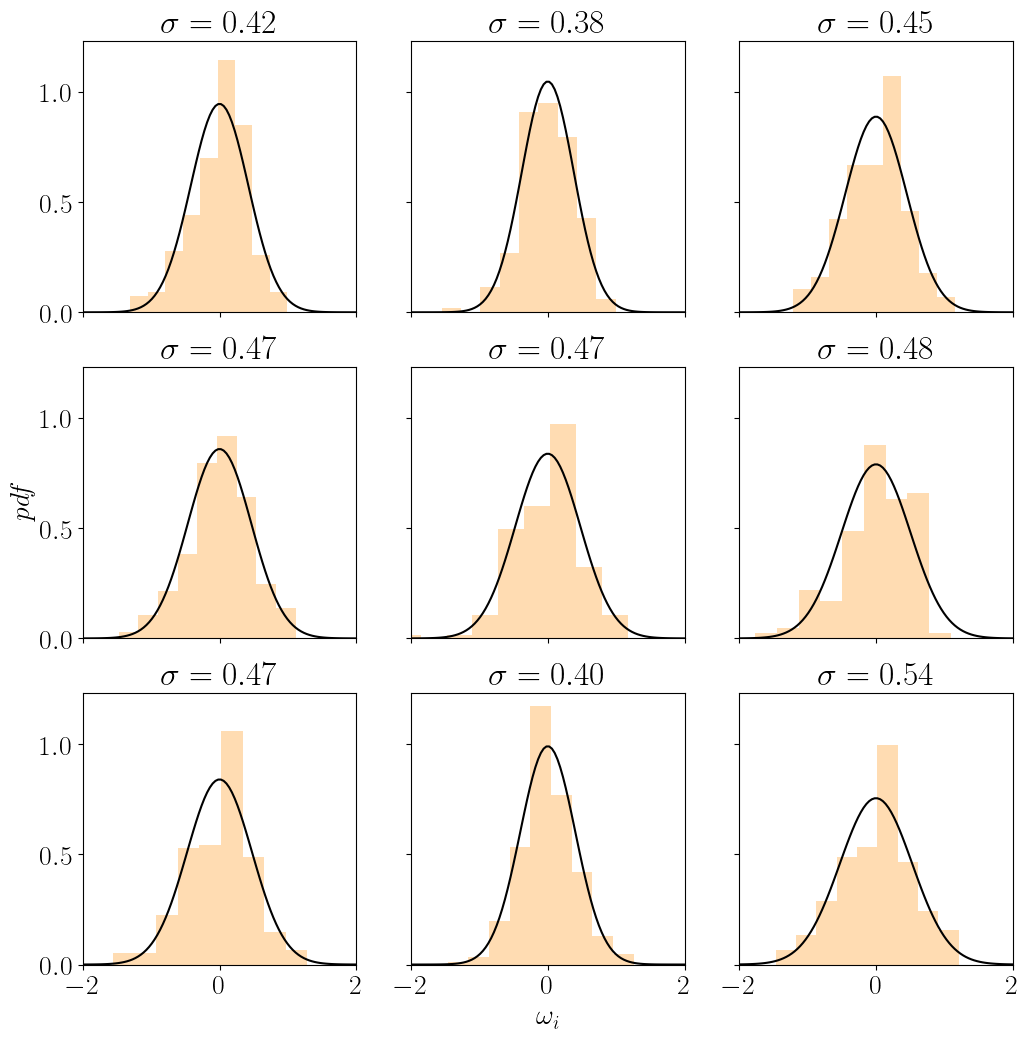

In [9]:
slopes = [] 

plt.rc('font', size=20)
fig1, axes1 = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 12))

fig2, axes2 = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 12))

l=0 

for (n, stages) in enumerate(straight_segments): 
    i, j = np.unravel_index(n, (3, 3))
    
    phases = np.array(list(map(stage_to_phase, stages)))
        
    
    shift(phases)
    theta_smooth = smooth(phases, 50)
    
    omega = np.mean(2*(1-np.cos(phi)))
    slope = np.sqrt(omega)
    slopes.append(slope)
    
    axes1[i, j].plot(theta_smooth, 'k-')
    l = max(l, len(theta_smooth))

    phi = theta_smooth[1:]-theta_smooth[:-1]


    BB, d = find_BB(phi, etas[j], grads[j])
    var, a = traj_logpdf(BB)

    print(a+np.log(d))

    omegas = BB[1:]-BB[:-1]

    axes2[i, j].hist(omegas, alpha=0.3, density=True, bins=9, color='darkorange')
    x = np.linspace(-2, 2, 100)
    axes2[i, j].set_title(r'$\sigma={:.2f}$'.format(sigmas[n]))
    axes2[i, j].plot(x, stats.norm.pdf(x, scale=np.sqrt(var)), color='black')


axes1[0, 0].set_xlim([0, l])    
axes1[2, 1].set_xlabel(r'$x$')
axes1[1, 0].set_ylabel(r'$\theta$')
fig1.savefig('omega_fit.pdf')

axes2[0, 0].set_xlim([-2, 2])
axes2[2, 1].set_xlabel(r'$\omega_i$')
axes2[1, 0].set_ylabel(r'$pdf$')
fig1.savefig('Figures/data.pdf')
fig2.savefig('Figures/omega_fit.pdf')
plt.show()

In [10]:
print('slope mean: ', np.mean(slopes))
print('slope std: ', np.std(slopes))

slope mean:  0.462226071174924
slope std:  0.030036722539176854


mean eta:  -0.43793250071929446
mean sigma:  0.45433496170314186
mean grad:  1.3193123369524853


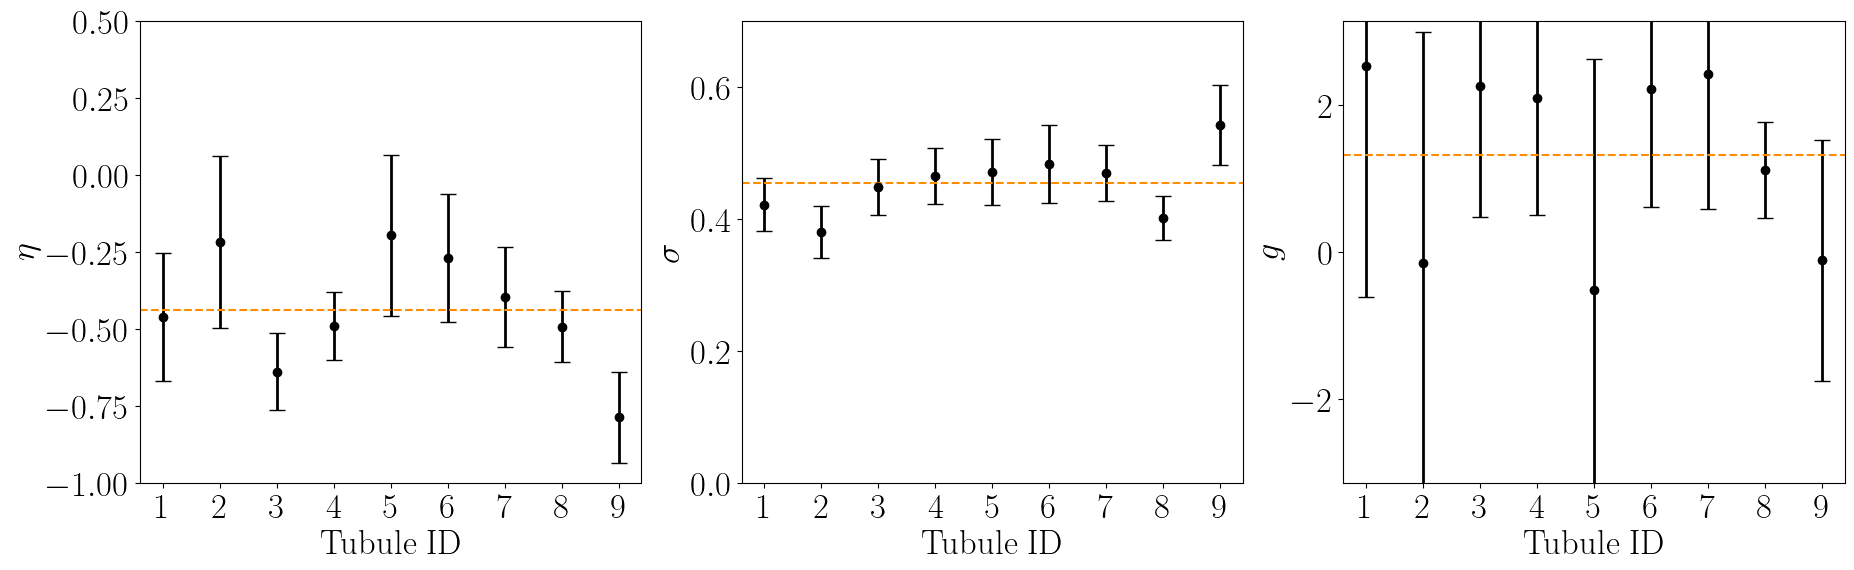

In [11]:
plt.rc('font', size=25)
plt.rc('text', usetex=True)

mean_eta = np.mean(etas)
mean_sigma = np.mean(sigmas)
mean_grad = np.mean(grads)

print('mean eta: ', mean_eta)
print('mean sigma: ', mean_sigma)
print('mean grad: ', mean_grad)

fig, axes = plt.subplots(1, 3, sharex=True, figsize=(22, 6))
tubules = np.arange(1, 10)
axes[0].errorbar(tubules, etas, etas_err, fmt='o', linewidth=2, color='k', capsize=6)
axes[0].axhline(y=mean_eta, linestyle='--', color='darkorange')
axes[0].set_ylabel(r'$\eta$')
axes[0].set_xlabel(r'Tubule ID')
axes[0].set_xticks(np.arange(1, 10))
axes[0].set_ylim([-1, 0.5])

axes[1].errorbar(tubules, sigmas, sigmas_err, fmt='o', linewidth=2, color='k', capsize=6)
axes[1].axhline(y=mean_sigma, linestyle='--', color='darkorange')
axes[1].set_ylabel(r'$\sigma$')
axes[1].set_xlabel(r'Tubule ID')
axes[1].set_ylim([0, 0.7])

axes[2].errorbar(tubules, grads, grads_err, fmt='o', linewidth=2, color='k', capsize=6)
axes[2].axhline(y=mean_grad, linestyle='--', color='darkorange')
axes[2].set_ylabel(r'$g$')
axes[2].set_ylim([-np.pi, np.pi])
axes[2].set_xlabel(r'Tubule ID')

plt.savefig('Figures/tubules.pdf')
plt.show() 
